# 09. Aggregated HDBSCAN Clustering

HDBSCAN clustering at three aggregation levels:
1. **Buyers** - cluster buyers by procurement behavior patterns
2. **Suppliers** - cluster suppliers by winning patterns (detect cartels)
3. **Buyer-Supplier Pairs** - cluster relationships (detect collusion)

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.data_loader import load_tenders, load_buyers, load_suppliers
from src.detectors import AggregatedHDBSCAN

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Started: 2026-01-30 21:53:50


## 1. Load Data

In [2]:
# Load 2023 data
tenders = load_tenders(years=[2023], sample_frac=0.1)
buyers = load_buyers()
suppliers = load_suppliers()

print(f"Tenders: {len(tenders):,}")
print(f"Buyers: {len(buyers):,}")
print(f"Suppliers: {len(suppliers):,}")

Scanning 2023...
Sampled to 349,174 records (10%)
Loaded buyers: 35,995
Loaded suppliers: 358,376
Tenders: 349,174
Buyers: 35,995
Suppliers: 358,376


## 2. Initialize Detector

In [3]:
detector = AggregatedHDBSCAN(
    min_cluster_size=10,
    min_samples=5,
    metric="euclidean",
)

## 3. Cluster Buyers

Find groups of buyers with similar procurement patterns. Outliers = suspicious buyers.

In [4]:
buyer_results = detector.cluster_buyers(tenders, buyers)

Clustering BUYERS...
  Using pre-computed buyer features
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'avg_tender_value', 'total_value']
  Buyers: 35,995
  Clusters: 413
  Noise (outliers): 18,031 (50.1%)
  Anomalies (score>=0.5): 18,570 (51.6%)


In [5]:
print("\nBuyer clustering results:")
print(f"  Total buyers: {len(buyer_results):,}")
print(f"  Clusters: {buyer_results['cluster'].nunique() - 1}")
print(f"  Noise (outliers): {buyer_results['is_noise'].sum():,}")
print(f"  Anomalies: {buyer_results['is_anomaly'].sum():,}")


Buyer clustering results:
  Total buyers: 35,995
  Clusters: 413
  Noise (outliers): 18,031
  Anomalies: 18,570


In [6]:
# Suspicious buyers (high outlier score)
suspicious_buyers = detector.get_suspicious_buyers(min_score=0.5)
print(f"\nSuspicious buyers (score >= 0.5): {len(suspicious_buyers):,}")

if len(suspicious_buyers) > 0:
    print("\nTop 10 by outlier score:")
    display(suspicious_buyers.nlargest(10, 'outlier_score'))


Suspicious buyers (score >= 0.5): 18,570

Top 10 by outlier score:


,buyer_id,cluster,probability,outlier_score,is_noise,is_anomaly,single_bidder_rate,competitive_rate,avg_discount_pct,supplier_diversity_index,total_tenders,avg_tender_value,total_value
0,40295882,-1,0.0,1.0,1,1,0.000334,0.000788,0.042697,0.016495,64226,2.966827e+03,3.201191e+09
1,38357766,-1,0.0,1.0,1,1,0.001007,0.003526,0.117540,0.073036,34945,1.191828e+04,2.950025e+08
2,39776588,-1,0.0,1.0,1,1,0.001285,0.001820,0.048113,0.103330,14186,1.983008e+04,2.832284e+08
3,41076819,-1,0.0,1.0,1,1,0.000161,0.000000,0.000515,0.071337,13377,1.631100e+04,2.187065e+08
4,38313100,-1,0.0,1.0,1,1,0.000000,0.000000,0.000000,0.000000,12330,0.000000e+00,3.961513e+07
5,38351628,-1,0.0,1.0,1,1,0.000246,0.003197,0.075250,0.130841,10927,1.836483e+04,1.745288e+08
6,03767831,-1,0.0,1.0,1,1,0.000000,0.000000,0.000000,0.000000,10052,0.000000e+00,2.614186e+09
7,21560045,-1,0.0,1.0,1,1,0.160263,0.240647,6.656740,0.452477,9972,2.144476e+06,1.779480e+10
8,38324552,-1,0.0,1.0,1,1,0.000000,0.000000,0.000000,0.000000,9708,0.000000e+00,2.906917e+07
9,19122935,-1,0.0,1.0,1,1,0.005405,0.015135,0.328641,0.033153,9699,1.261466e+04,9.233682e+07


In [7]:
# Compare suspicious vs normal buyers
if len(suspicious_buyers) > 0 and 'single_bidder_rate' in buyer_results.columns:
    normal_buyers = buyer_results[buyer_results['outlier_score'] < 0.5]
    
    print("Comparison: Suspicious vs Normal Buyers")
    print("="*50)
    
    for col in ['single_bidder_rate', 'competitive_rate', 'total_value']:
        if col in buyer_results.columns:
            sus_mean = suspicious_buyers[col].mean()
            norm_mean = normal_buyers[col].mean()
            print(f"{col}:")
            print(f"  Suspicious: {sus_mean:.3f}")
            print(f"  Normal:     {norm_mean:.3f}")

Comparison: Suspicious vs Normal Buyers
single_bidder_rate:
  Suspicious: 0.056
  Normal:     0.012
competitive_rate:
  Suspicious: 0.054
  Normal:     0.015
total_value:
  Suspicious: 183149734.765
  Normal:     23978523.905


## 4. Cluster Suppliers

Find groups of suppliers with similar winning patterns. Outliers = potential cartel members or anomalous suppliers.

In [8]:
supplier_results = detector.cluster_suppliers(tenders, suppliers)

Clustering SUPPLIERS...
  Computing supplier features from tenders (Polars)...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors']
  Suppliers: 79,311
  Clusters: 2528
  Noise (outliers): 14,919 (18.8%)
  Anomalies (score>=0.5): 22,020 (27.8%)


In [9]:
print("\nSupplier clustering results:")
print(f"  Total suppliers: {len(supplier_results):,}")
print(f"  Clusters: {supplier_results['cluster'].nunique() - 1}")
print(f"  Noise (outliers): {supplier_results['is_noise'].sum():,}")
print(f"  Anomalies: {supplier_results['is_anomaly'].sum():,}")


Supplier clustering results:
  Total suppliers: 79,311
  Clusters: 2528
  Noise (outliers): 14,919
  Anomalies: 22,020


In [10]:
# Suspicious suppliers
suspicious_suppliers = detector.get_suspicious_suppliers(min_score=0.5)
print(f"\nSuspicious suppliers (score >= 0.5): {len(suspicious_suppliers):,}")

if len(suspicious_suppliers) > 0:
    print("\nTop 10 by outlier score:")
    display(suspicious_suppliers.nlargest(10, 'outlier_score'))


Suspicious suppliers (score >= 0.5): 22,020

Top 10 by outlier score:


,supplier_id,cluster,probability,outlier_score,is_noise,is_anomaly,total_awards,total_value,avg_award_value,buyer_count,single_bidder_rate,avg_competitors
5,2950302836,-1,0.0,1.0,1,1,16,40670.00,2.541875e+03,7,0.000000,0.000000
6,3718110327,-1,0.0,1.0,1,1,9,714410.54,7.937895e+04,3,0.000000,0.000000
8,33966190,-1,0.0,1.0,1,1,4,42918309.82,1.072958e+07,4,0.500000,0.500000
11,00131512,-1,0.0,1.0,1,1,105,13532429.13,1.288803e+05,89,0.000000,0.000000
16,3203607950,876,0.0,1.0,0,1,1,10984.00,1.098400e+04,1,0.000000,0.000000
18,ФОП Остапенко Анатолій Петрович,-1,0.0,1.0,1,1,1,1317.00,1.317000e+03,1,0.000000,0.000000
24,40893818,-1,0.0,1.0,1,1,3,8136212.79,2.712071e+06,2,0.000000,1.333333
36,2830124057,-1,0.0,1.0,1,1,20,15824.82,7.912410e+02,4,0.000000,0.000000
38,2717123678,-1,0.0,1.0,1,1,3,581650.00,1.938833e+05,3,0.333333,0.333333
40,30287372,-1,0.0,1.0,1,1,7,369950.70,5.285010e+04,6,0.000000,0.285714


In [11]:
# Supplier clusters analysis
print("\nSupplier Cluster Analysis:")
print("="*50)

cluster_stats = supplier_results.groupby('cluster').agg({
    'supplier_id': 'count',
    'total_awards': 'mean',
    'total_value': 'mean',
    'single_bidder_rate': 'mean',
}).round(2)
cluster_stats.columns = ['count', 'avg_awards', 'avg_value', 'single_bidder_rate']
cluster_stats = cluster_stats.sort_values('count', ascending=False)

display(cluster_stats.head(10))


Supplier Cluster Analysis:


,count,avg_awards,avg_value,single_bidder_rate
cluster,,,,
-1,14919,11.43,4790820.59,0.09
2484,561,12.39,270835.31,0.01
2506,389,12.80,199547.86,0.01
1443,305,1.00,9998.34,0.00
999,264,1.00,4999.97,0.00
615,259,1.00,2999.98,0.00
2508,254,15.39,222671.78,0.00
1444,229,1.00,19999.54,0.00
1260,228,1.00,5999.96,0.00


## 5. Cluster Buyer-Supplier Pairs

Find groups of relationships with similar patterns. Outliers = suspicious collusive relationships.

In [12]:
pair_results = detector.cluster_pairs(tenders, min_contracts=3)

Clustering BUYER-SUPPLIER PAIRS...
  Computing pair features from tenders (Polars)...
  Pairs with 3+ contracts: 21,742
  Features: ['contracts_count', 'total_value', 'avg_value', 'single_bidder_rate', 'exclusivity_buyer', 'exclusivity_supplier']
  Clusters: 59
  Noise (outliers): 6,824 (31.4%)
  Anomalies (score>=0.5): 6,875 (31.6%)


In [13]:
if len(pair_results) > 0:
    print("\nBuyer-Supplier pair clustering results:")
    print(f"  Total pairs: {len(pair_results):,}")
    print(f"  Clusters: {pair_results['cluster'].nunique() - 1}")
    print(f"  Noise (outliers): {pair_results['is_noise'].sum():,}")
    print(f"  Anomalies: {pair_results['is_anomaly'].sum():,}")


Buyer-Supplier pair clustering results:
  Total pairs: 21,742
  Clusters: 59
  Noise (outliers): 6,824
  Anomalies: 6,875


In [14]:
# Suspicious pairs (potential collusion)
if len(pair_results) > 0:
    suspicious_pairs = detector.get_suspicious_pairs(min_score=0.5)
    print(f"\nSuspicious pairs (score >= 0.5): {len(suspicious_pairs):,}")

    if len(suspicious_pairs) > 0:
        print("\nTop 10 suspicious pairs by outlier score:")
        display(suspicious_pairs.nlargest(10, 'outlier_score')[[
            'buyer_id', 'supplier_id', 'outlier_score', 
            'contracts_count', 'total_value', 'single_bidder_rate',
            'exclusivity_buyer', 'exclusivity_supplier'
        ]])


Suspicious pairs (score >= 0.5): 6,875

Top 10 suspicious pairs by outlier score:


,buyer_id,supplier_id,outlier_score,contracts_count,total_value,single_bidder_rate,exclusivity_buyer,exclusivity_supplier
0,43032664,3098015451,1.0,5,183235.00,0.000000,0.034483,1.000000
4,05399248,2473217639,1.0,3,1254068.00,0.666667,0.033333,1.000000
6,08733794,2643223106,1.0,24,44335.00,0.000000,0.196721,1.000000
9,04359152,40150352,1.0,6,4304068.41,0.000000,0.117647,0.333333
11,24978957,2652607694,1.0,5,642201.20,0.200000,0.416667,0.500000
13,44168316,34239034,1.0,6,96916.80,0.000000,0.260870,0.084507
14,41527468,3274612209,1.0,13,59995.00,0.000000,0.464286,0.650000
15,01999661,2661003489,1.0,6,16732.00,0.000000,0.153846,0.857143
16,42406274,2447200330,1.0,7,19078.40,0.000000,0.304348,0.205882
18,44133660,32429709,1.0,6,175428.79,0.000000,0.067416,0.461538


In [15]:
# Highly exclusive relationships (potential red flags)
if len(pair_results) > 0:
    exclusive_pairs = pair_results[
        (pair_results['exclusivity_buyer'] > 0.5) | 
        (pair_results['exclusivity_supplier'] > 0.5)
    ]
    print(f"\nHighly exclusive relationships (>50% exclusivity): {len(exclusive_pairs):,}")
    
    if len(exclusive_pairs) > 0:
        print("\nTop 10 by buyer exclusivity:")
        display(exclusive_pairs.nlargest(10, 'exclusivity_buyer')[[
            'buyer_id', 'supplier_id', 'contracts_count', 'total_value',
            'exclusivity_buyer', 'exclusivity_supplier', 'single_bidder_rate'
        ]])


Highly exclusive relationships (>50% exclusivity): 9,570

Top 10 by buyer exclusivity:


,buyer_id,supplier_id,contracts_count,total_value,exclusivity_buyer,exclusivity_supplier,single_bidder_rate
35,38335906,2452101552,3,7094.00,1.0,1.000000,0.0
37,26629586,88888888,3,53200.00,1.0,0.000983,0.0
80,43022326,2643914702,3,10109.62,1.0,0.600000,0.0
136,40330848,3537507717,4,55420.00,1.0,0.500000,0.0
215,43995275,2977316791,3,9650.00,1.0,0.250000,0.0
222,37411628,3166801581,4,3080.03,1.0,0.114286,0.0
389,44178125,3256402894,3,55676.68,1.0,0.750000,0.0
651,23210941,2547302195,3,29324.70,1.0,0.300000,0.0
716,34263025,2445911192,16,14886.33,1.0,0.114286,0.0
883,26395510,2174524661,10,37581.00,1.0,1.000000,0.0


## 6. Summary

In [16]:
summaries = detector.summary()

for level, summary_df in summaries.items():
    print(f"\n{level.upper()} Summary:")
    print("="*40)
    display(summary_df)


BUYERS Summary:


,metric,value
0,total,35995.000000
1,clusters,414.000000
2,noise,18031.000000
3,noise_pct,50.093068
4,anomalies,18570.000000
5,anomaly_pct,51.590499



SUPPLIERS Summary:


,metric,value
0,total,79311.000000
1,clusters,2529.000000
2,noise,14919.000000
3,noise_pct,18.810758
4,anomalies,22020.000000
5,anomaly_pct,27.764118



PAIRS Summary:


,metric,value
0,total,21742.000000
1,clusters,60.000000
2,noise,6824.000000
3,noise_pct,31.386257
4,anomalies,6875.000000
5,anomaly_pct,31.620826


## 7. Visualizations

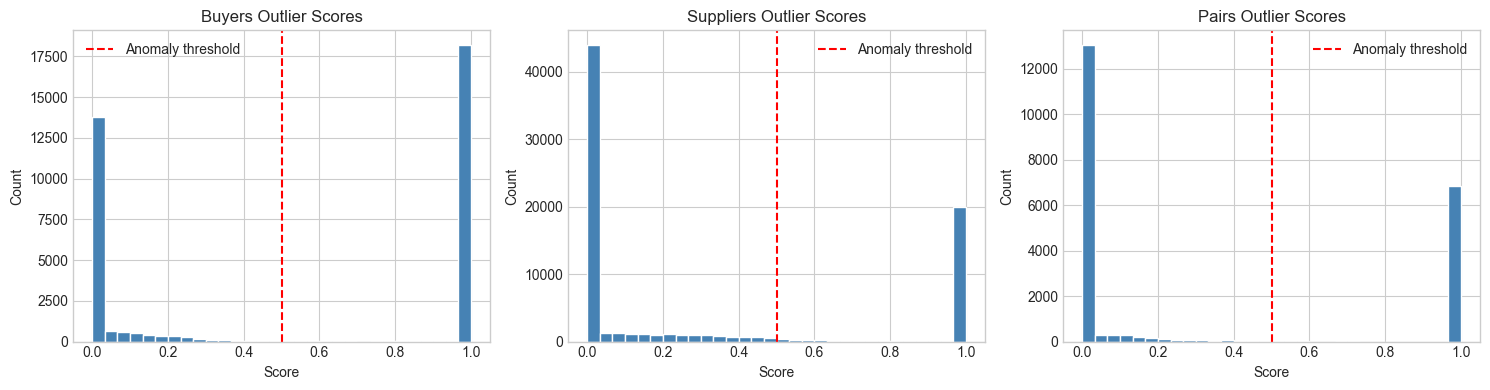

In [17]:
# Outlier score distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, results) in zip(axes, [
    ('Buyers', detector.buyer_results_),
    ('Suppliers', detector.supplier_results_),
    ('Pairs', detector.pair_results_),
]):
    if results is not None and len(results) > 0:
        results['outlier_score'].hist(bins=30, ax=ax, color='steelblue', edgecolor='white')
        ax.axvline(x=0.5, color='red', linestyle='--', label='Anomaly threshold')
        ax.set_title(f'{name} Outlier Scores')
        ax.set_xlabel('Score')
        ax.set_ylabel('Count')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'{name} Outlier Scores')

plt.tight_layout()
plt.savefig('../results/aggregated_hdbscan_scores.png', dpi=150, bbox_inches='tight')
plt.show()

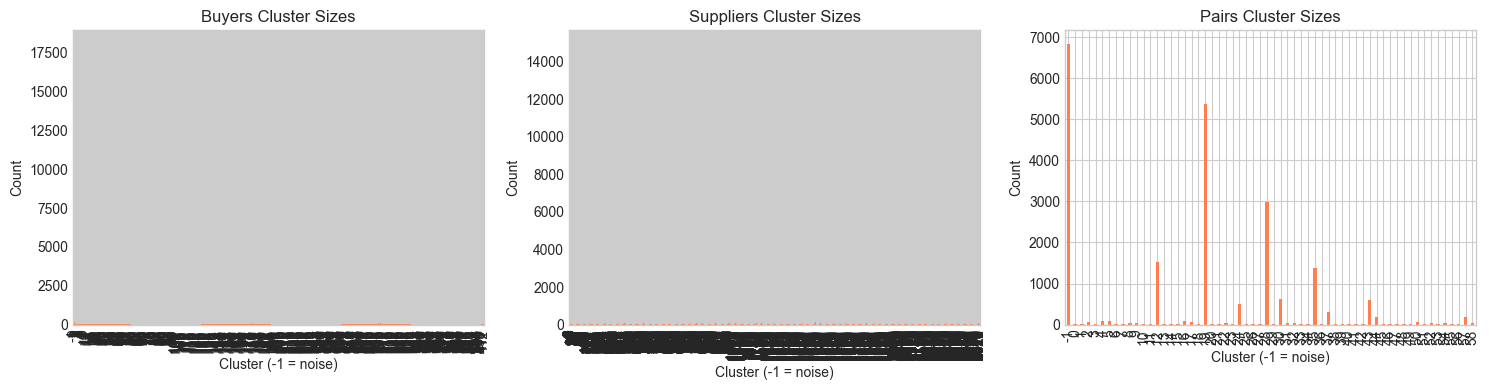

In [18]:
# Cluster sizes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, results) in zip(axes, [
    ('Buyers', detector.buyer_results_),
    ('Suppliers', detector.supplier_results_),
    ('Pairs', detector.pair_results_),
]):
    if results is not None and len(results) > 0:
        cluster_sizes = results['cluster'].value_counts().sort_index()
        cluster_sizes.plot(kind='bar', ax=ax, color='coral')
        ax.set_title(f'{name} Cluster Sizes')
        ax.set_xlabel('Cluster (-1 = noise)')
        ax.set_ylabel('Count')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'{name} Cluster Sizes')

plt.tight_layout()
plt.savefig('../results/aggregated_hdbscan_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Results

In [19]:
# Save anomalies from each level
if detector.buyer_results_ is not None:
    suspicious_buyers = detector.get_suspicious_buyers(0.5)
    suspicious_buyers.to_csv('../results/hdbscan_suspicious_buyers.csv', index=False)
    print(f"Saved {len(suspicious_buyers)} suspicious buyers")

if detector.supplier_results_ is not None:
    suspicious_suppliers = detector.get_suspicious_suppliers(0.5)
    suspicious_suppliers.to_csv('../results/hdbscan_suspicious_suppliers.csv', index=False)
    print(f"Saved {len(suspicious_suppliers)} suspicious suppliers")

if detector.pair_results_ is not None and len(detector.pair_results_) > 0:
    suspicious_pairs = detector.get_suspicious_pairs(0.5)
    suspicious_pairs.to_csv('../results/hdbscan_suspicious_pairs.csv', index=False)
    print(f"Saved {len(suspicious_pairs)} suspicious pairs")

print(f"\nCompleted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Saved 18570 suspicious buyers
Saved 22020 suspicious suppliers
Saved 6875 suspicious pairs

Completed: 2026-01-30 21:54:07
